<a href="https://colab.research.google.com/github/AnikaD15/EN-HU-Translation/blob/main/milestone3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd

In [2]:
## Config 
batch_size = 64  # Batch size for training.
epochs = 100  # Number of epochs to train for.
latent_dim = 256  # Latent dimensionality of the encoding space.
num_samples = 10000  # Number of samples to train on.
# Path to the data txt file on disk.
base_path = "/content/drive/MyDrive/DeepLearning/"
data_path1 = base_path + "hun1.txt"
data_path2 = base_path + "hun2.tsv"

# Functions

In [28]:
def getLines(data_path):
  with open(data_path, "r", encoding="utf-8") as f:
    lines = f.read().split("\n")
    new_lines = list()

    # initializing punctuations string
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_~'''

    # Removing punctuations in string
    # Using loop + punctuation string
    for line in lines:
      for ele in line:
          if ele in punc:
              line = line.replace(ele, "")
      new_lines.append(line)

  return new_lines

In [4]:
def getTextAndChars(lines):
  input_texts = []
  target_texts = []
  input_characters = set()
  target_characters = set()

  for line in lines[: min(num_samples, len(lines) - 1)]:
    # input_text, target_text, _ = line.split("\t")
    target_text, input_text, _ = line.split("\t")
    # We use "tab" as the "start sequence" character
    # for the targets, and "\n" as "end sequence" character.
    target_text = "\t" + target_text + "\n"
    input_texts.append(input_text)
    target_texts.append(target_text)

    for char in input_text:
        if char not in input_characters:
            input_characters.add(char)

    for char in target_text:
        if char not in target_characters:
            target_characters.add(char)

  input_characters = sorted(list(input_characters))
  target_characters = sorted(list(target_characters)) 

  return input_texts, target_texts, input_characters, target_characters 



In [5]:
def numTokens(charSet):
  return len(charSet)

In [6]:
def maxSeqLength(text):
  return max([len(txt) for txt in text])

In [7]:
def makeTokenIndex(charSet):
  return dict([(char, i) for i, char in enumerate(charSet)])

In [8]:
def setInputAndTargetData(input_text, target_text, input_token_index, target_token_index):
  encoder_input_data = np.zeros(
      (len(input_text), max_encoder_seq_length, num_encoder_tokens), dtype="float32"
  )
  decoder_input_data = np.zeros(
      (len(input_text), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
  )
  decoder_target_data = np.zeros(
      (len(input_text), max_decoder_seq_length, num_decoder_tokens), dtype="float32"
  )

  
  for i, (input_text, target_text) in enumerate(zip(input_text, target_text)):
    for t, char in enumerate(input_text):
        encoder_input_data[i, t, input_token_index[char]] = 1.0

    encoder_input_data[i, t + 1 :, input_token_index[" "]] = 1.0
    for t, char in enumerate(target_text):
        # decoder_target_data is ahead of decoder_input_data by one timestep
        decoder_input_data[i, t, target_token_index[char]] = 1.0
        if t > 0:
            # decoder_target_data will be ahead by one timestep
            # and will not include the start character.
            decoder_target_data[i, t - 1, target_token_index[char]] = 1.0
    decoder_input_data[i, t + 1 :, target_token_index[" "]] = 1.0
    decoder_target_data[i, t:, target_token_index[" "]] = 1.0

  return encoder_input_data, decoder_input_data, decoder_target_data

In [9]:
# Define an input sequence and process it.
def getInputsAndOutputs(num_encoder_tokens, num_decoder_tokens, latent_dim=latent_dim):
  encoder_inputs = keras.Input(shape=(None, num_encoder_tokens))
  encoder = keras.layers.LSTM(latent_dim, return_state=True)
  encoder_outputs, state_h, state_c = encoder(encoder_inputs)

  # We discard `encoder_outputs` and only keep the states.
  encoder_states = [state_h, state_c]

  # Set up the decoder, using `encoder_states` as initial state.
  decoder_inputs = keras.Input(shape=(None, num_decoder_tokens))

  # We set up our decoder to return full output sequences,
  # and to return internal states as well. We don't use the
  # return states in the training model, but we will use them in inference.
  decoder_lstm = keras.layers.LSTM(latent_dim, return_sequences=True, return_state=True)
  decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
  decoder_dense = keras.layers.Dense(num_decoder_tokens, activation="softmax")
  decoder_outputs = decoder_dense(decoder_outputs)

  return encoder_inputs, decoder_inputs, decoder_outputs

In [10]:
def splitData(data, valid_split, test_split):
  # array index boundary
  v_point = int(len(data)*(1-valid_split-test_split))
  t_point = int(len(data)*(1-test_split))

  data_train = data[:t_point]
  data_valid = data[v_point:t_point]
  data_test = data[t_point:]

  return data_train, data_valid, data_test

In [11]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    states_value = encoder_model.predict(input_seq)

    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1, 1, num_decoder_tokens))
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0, target_token_index["\t"]] = 1.0

    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ""
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value)

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_char = reverse_target_char_index[sampled_token_index]
        decoded_sentence += sampled_char

        # Exit condition: either hit max length
        # or find stop character.
        if sampled_char == "\n" or len(decoded_sentence) > max_decoder_seq_length:
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1, 1, num_decoder_tokens))
        target_seq[0, 0, sampled_token_index] = 1.0

        # Update states
        states_value = [h, c]
        
    return decoded_sentence

In [29]:
def duplicates(lst, item):
  return [i for i, x in enumerate(lst) if x == item]

## Prepare Data

In [12]:
# Vectorize the data.
lines1 = getLines(data_path1)
lines2 = getLines(data_path2)

lines = lines1+lines2

input_text, target_text, input_characters, target_characters = getTextAndChars(lines)

num_encoder_tokens = numTokens(input_characters)
num_decoder_tokens = numTokens(target_characters)
max_encoder_seq_length = maxSeqLength(input_text)
max_decoder_seq_length = maxSeqLength(target_text)

print("Number of samples:", len(input_text))
print("Number of unique input tokens:", num_encoder_tokens)
print("Number of unique output tokens:", num_decoder_tokens)
print("Max sequence length for inputs:", max_encoder_seq_length)
print("Max sequence length for outputs:", max_decoder_seq_length)

# character's lexographical order
input_token_index = makeTokenIndex(input_characters) 
target_token_index = makeTokenIndex(target_characters)

# encoder_input_data, decoder_input_data, decoder_target_data = setInputAndTargetData(input_text, target_text, input_token_index, target_token_index)
                                                                                    
encoder_inputs, decoder_inputs, decoder_outputs = getInputsAndOutputs(num_encoder_tokens, num_decoder_tokens)                                                                          


Number of samples: 10000
Number of unique input tokens: 81
Number of unique output tokens: 72
Max sequence length for inputs: 54
Max sequence length for outputs: 17


## Split Data

In [13]:
# training, validation, test data
valid_split = 0.2
test_split  = 0.1

input_text_train, input_text_valid, input_text_test = splitData(input_text, valid_split, test_split)
target_text_train, target_text_valid, target_text_test = splitData(target_text, valid_split, test_split)

## Define Model

In [14]:
# Define the model that will turn 
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = keras.Model([encoder_inputs, decoder_inputs], decoder_outputs)

## Train Model

In [15]:
# training, validation, test encoder/decoder data
encoder_input_data_train, decoder_input_data_train, decoder_target_data_train = setInputAndTargetData(input_text_train, target_text_train, input_token_index, target_token_index)
encoder_input_data_valid, decoder_input_data_valid, decoder_target_data_valid = setInputAndTargetData(input_text_valid, target_text_valid, input_token_index, target_token_index)
encoder_input_data_test, decoder_input_data_test, decoder_target_data_test = setInputAndTargetData(input_text_test, target_text_test, input_token_index, target_token_index)

In [16]:
model.compile(
    optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
)

In [17]:
es = EarlyStopping(monitor='val_accuracy', 
                   patience=20, verbose=1,
                   restore_best_weights=True)

In [18]:
model.fit(
    [encoder_input_data_train, decoder_input_data_train],
    decoder_target_data_train,
    batch_size=batch_size,
    callbacks=[es],
    epochs=epochs,
    validation_data = ([encoder_input_data_valid, decoder_input_data_valid],
    decoder_target_data_valid)
)
# Save model
model.save(base_path + "model")

Epoch 1/100
141/141 [==============================] - 13s 41ms/step - loss: 2.4193 - accuracy: 0.3588 - val_loss: 2.5268 - val_accuracy: 0.3121
Epoch 2/100
141/141 [==============================] - 4s 32ms/step - loss: 1.8510 - accuracy: 0.4916 - val_loss: 2.0185 - val_accuracy: 0.4132
Epoch 3/100
141/141 [==============================] - 5s 32ms/step - loss: 1.5789 - accuracy: 0.5423 - val_loss: 1.7571 - val_accuracy: 0.4871
Epoch 4/100
141/141 [==============================] - 4s 32ms/step - loss: 1.4538 - accuracy: 0.5745 - val_loss: 1.6585 - val_accuracy: 0.5099
Epoch 5/100
141/141 [==============================] - 4s 32ms/step - loss: 1.3595 - accuracy: 0.6013 - val_loss: 1.5661 - val_accuracy: 0.5299
Epoch 6/100
141/141 [==============================] - 4s 32ms/step - loss: 1.2881 - accuracy: 0.6206 - val_loss: 1.5480 - val_accuracy: 0.5391
Epoch 7/100
141/141 [==============================] - 4s 32ms/step - loss: 1.2266 - accuracy: 0.6371 - val_loss: 1.4434 - val_accuracy

INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/model/assets


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DeepLearning/model/assets


## Evaluate Model

In [19]:
# model = keras.models.load_model(base_path + "model")
# model.compile(
#     optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"]
# )

In [20]:
model.evaluate([encoder_input_data_test, decoder_input_data_test], decoder_target_data_test)

32/32 [==============================] - 0s 15ms/step - loss: 2.2626 - accuracy: 0.6428


[2.2625625133514404, 0.6428235173225403]

In [21]:
# Define sampling models
# Restore the model and construct the encoder and decoder.
encoder_inputs = model.input[0]  # input_1
encoder_outputs, state_h_enc, state_c_enc = model.layers[2].output  # lstm_1
encoder_states = [state_h_enc, state_c_enc]
encoder_model = keras.Model(encoder_inputs, encoder_states)

decoder_inputs = model.input[1]  # input_2
decoder_state_input_h = keras.Input(shape=(latent_dim,))
decoder_state_input_c = keras.Input(shape=(latent_dim,))
decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
decoder_lstm = model.layers[3]
decoder_outputs, state_h_dec, state_c_dec = decoder_lstm(
    decoder_inputs, initial_state=decoder_states_inputs
)
decoder_states = [state_h_dec, state_c_dec]
decoder_dense = model.layers[4]
decoder_outputs = decoder_dense(decoder_outputs)
decoder_model = keras.Model(
    [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
)

# Reverse-lookup token index to decode sequences back to
# something readable.
reverse_input_char_index = dict((i, char) for char, i in input_token_index.items())
reverse_target_char_index = dict((i, char) for char, i in target_token_index.items())

In [22]:
corpus_scores = list()
dim_list = list()

In [ ]:
n = len(input_text_test)
sentence_scores = list()
sentence_1gram_scores = list()
decoded_sentences = list(list())
target_sentences = list(list(list()))
text=""""""

with open(base_path+"decode.txt", "w") as df: 

    for seq_index in range(n):
        # Take one sequence (part of the training set)
        # for trying out decoding.
        input_seq = encoder_input_data_test[seq_index : seq_index + 1]
        decoded_sentence = decode_sequence(input_seq)

        indices = duplicates(input_text, input_text_test[seq_index])

        # sentence score
        sentence_scores.append(sentence_bleu([[target_text[i] for i in indices]], [decoded_sentence]))
        sentence_1gram_scores.append(sentence_bleu([[target_text[i] for i in indices]], [decoded_sentence], weights=(1, 0, 0, 0)))

        #corpus score
        target_sentences.append([[target_text[i] for i in indices]])
        decoded_sentences.append([decoded_sentence])

        text+="-"
        text+="Input sentence:{}\n".format(input_text_test[seq_index])
        text+="Target sentence:\n"

        for i in indices:
            text+=target_text[i]
        
        text+="Decoded sentence:{}\n".format(decoded_sentence) 

    print(text, file=df)
    df.close()

corpus_scores.append(corpus_bleu(target_sentences, decoded_sentences))
dim_list.append(latent_dim)

### Graph Plot

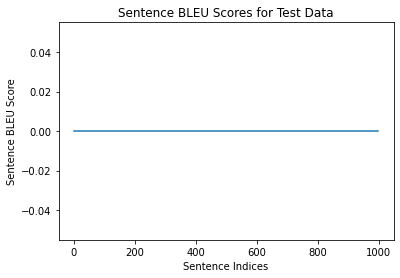

In [35]:
import matplotlib.pyplot as plt
# x axis values
x = [i for i in range(len(sentence_scores))]

# corresponding y axis values
y = sentence_scores
 
# plotting the points
plt.plot(x, y)
 
# naming the x axis
plt.xlabel('Sentence Indices')
# naming the y axis
plt.ylabel('Sentence BLEU Score')
 
# giving a title to my graph
plt.title('Sentence BLEU Scores for Test Data')
 
# function to show the plot
plt.show()

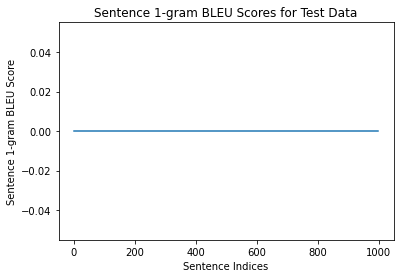

In [37]:
# x axis values
x = [i for i in range(len(sentence_1gram_scores))]

# corresponding y axis values
y = sentence_1gram_scores
 
# plotting the points
plt.plot(x, y)
 
# naming the x axis
plt.xlabel('Sentence Indices')
# naming the y axis
plt.ylabel('Sentence 1-gram BLEU Score')
 
# giving a title to my graph
plt.title('Sentence 1-gram BLEU Scores for Test Data')
 
# function to show the plot
plt.show()